In [138]:
import pandas as pd
import numpy as np
from scipy import stats as sps
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from scipy.stats import zscore

In [139]:
data = pd.read_csv('variables_traintest2-selene.csv')

In [140]:
data.head()

,record,date,amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,card_ps_30d_count,...,card-state_ps_0d_ps3d_number,card-state_ps_1d_ps3d_number,card-state_ps_0d_ps3d_amount,card-state_ps_1d_ps3d_amount,U_smooth_merch,U_smooth_card,weekday,fraud,random,weekday_risk
0,1,2010-01-01,3.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000643,1.000643,4,0,0.203250,0.025994
1,2,2010-01-01,31.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000894,1.000894,4,0,0.408200,0.025994
2,3,2010-01-01,178.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000894,1.000894,4,0,0.577225,0.025994
3,4,2010-01-01,3.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000643,1.000643,4,0,0.175165,0.025994
4,5,2010-01-01,3.62,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,1.000643,1.000643,4,0,0.339832,0.025994


In [141]:
data.drop(['weekday','amount'],inplace=True,axis=1)

In [142]:
data.head()

,record,date,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,card_ps_30d_count,card_ps_0d_average,...,card-state_ps_30d_ActualTotal,card-state_ps_0d_ps3d_number,card-state_ps_1d_ps3d_number,card-state_ps_0d_ps3d_amount,card-state_ps_1d_ps3d_amount,U_smooth_merch,U_smooth_card,fraud,random,weekday_risk
0,1,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.620000e+08,0.0,0.0,0.0,0.0,1.000643,1.000643,0,0.203250,0.025994
1,2,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.142000e+09,0.0,0.0,0.0,0.0,1.000894,1.000894,0,0.408200,0.025994
2,3,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,1.784900e+10,0.0,0.0,0.0,0.0,1.000894,1.000894,0,0.577225,0.025994
3,4,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.620000e+08,0.0,0.0,0.0,0.0,1.000643,1.000643,0,0.175165,0.025994
4,5,2010-01-01,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.620000e+00,...,1.000000e+00,3.0,3.0,3.0,3.0,1.000643,1.000643,0,0.339832,0.025994


In [143]:
goods = data[data['fraud'] == 0]
bads = data[data['fraud'] == 1]
numbads = len(bads)

In [144]:
KSFDR = pd.DataFrame()
mydata = data.iloc[:,2:]
KSFDR.reindex(mydata.columns)
KSFDR['ks']=0

for column in mydata.columns:
    KSFDR.loc[column,'ks'] = sps.ks_2samp(goods[column],bads[column])[0]

In [145]:
KSFDR

,ks
card_#d_since,0.284889
card_ps_0d_count,0.332675
card_ps_1d_count,0.373342
card_ps_3d_count,0.400203
card_ps_7d_count,0.395768
...,...
U_smooth_merch,0.304692
U_smooth_card,0.391740
fraud,1.000000
random,0.024636


In [146]:
topRows = int(round(len(mydata)*0.03))
for column in mydata.columns:
    temp1 = mydata.sort_values(column, ascending=False).head(topRows)
    temp2 = mydata.sort_values(column, ascending=True).head(topRows)
    needed1 = temp1.loc[:,'fraud']
    needed2 = temp2.loc[:,'fraud']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[column,'FDR']=FDRate



In [147]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending=True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending=True)
KSFDR['average_rank'] = (KSFDR['rank_ks']+KSFDR['rank_FDR'])/2

In [148]:
KSFDR.sort_values(by=['average_rank'],ascending=False,inplace=True)

In [149]:
KSFDR.to_csv('KSFDR2.csv')

In [150]:
KSFDR=KSFDR.reset_index()

In [151]:
KSFDR=KSFDR.rename(columns={'index':'var'})

In [152]:
KSFDR

,var,ks,FDR,rank_ks,rank_FDR,average_rank
0,fraud,1.000000,1.000000,324.0,324.0,324.00
1,card-state_ps_7d_total,0.551008,0.502273,323.0,322.0,322.50
2,card_ps_3d_total,0.529362,0.522727,320.0,323.0,321.50
3,card_ps_7d_total,0.547922,0.488636,322.0,320.0,321.00
4,card-state_ps_3d_total,0.537852,0.478409,321.0,319.0,320.00
...,...,...,...,...,...,...
319,merch#_ps_0d_count,0.217429,0.005682,39.0,2.0,20.50
320,merch#_ps_30d_count,0.216705,0.004545,38.0,1.0,19.50
321,card_ps_30d_ActualTotal,0.190964,0.025000,19.0,18.5,18.75
322,card_ps_14d_ActualTotal,0.123962,0.040909,2.0,27.5,14.75


## Feature Selection?

In [153]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
#drop 'random', 'fraud' and select top 80 variables from KSFDR 
DFfs = KSFDR.loc[~((KSFDR['var']=='fraud') | (KSFDR['var']=='random'))]
var_top80 = DFfs.nlargest(80,['average_rank']).copy()
var_top80_list = list(var_top80['var'])
var_top80_list

['card-state_ps_7d_total',
 'card_ps_3d_total',
 'card_ps_7d_total',
 'card-state_ps_3d_total',
 'card-state_ps_14d_total',
 'card_ps_1d_total',
 'card_ps_14d_total',
 'card-state_ps_3d_maximum',
 'card_ps_1d_average',
 'card-state_ps_1d_total',
 'card-state_ps_7d_maximum',
 'card_ps_14d_maximum',
 'card_ps_7d_maximum',
 'card_ps_3d_average',
 'card-zip_ps_7d_total',
 'card_ps_3d_maximum',
 'card-zip_ps_3d_total',
 'card-zip_ps_14d_total',
 'card-state_ps_30d_total',
 'card_ps_1d_maximum',
 'card_ps_0d_total',
 'card-merchant_ps_7d_total',
 'card-merchant_ps_14d_total',
 'card-state_ps_1d_maximum',
 'card-merchant_ps_3d_total',
 'card_ps_0d_maximum',
 'card-state_ps_3d_average',
 'card-merchant_ps_3d_maximum',
 'card-state_ps_1d_average',
 'card-state_ps_1d_median',
 'card-zip_ps_30d_total',
 'card_ps_0d_average',
 'card_ps_7d_average',
 'card-state_ps_7d_average',
 'card_ps_30d_total',
 'card-zip_ps_3d_maximum',
 'card-state_ps_14d_maximum',
 'card-state_ps_3d_median',
 'card_ps_1d_me

### RFECV

In [155]:
tt=data.copy()

In [156]:
tt.head()

,record,date,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,card_ps_30d_count,card_ps_0d_average,...,card-state_ps_30d_ActualTotal,card-state_ps_0d_ps3d_number,card-state_ps_1d_ps3d_number,card-state_ps_0d_ps3d_amount,card-state_ps_1d_ps3d_amount,U_smooth_merch,U_smooth_card,fraud,random,weekday_risk
0,1,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.620000e+08,0.0,0.0,0.0,0.0,1.000643,1.000643,0,0.203250,0.025994
1,2,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.142000e+09,0.0,0.0,0.0,0.0,1.000894,1.000894,0,0.408200,0.025994
2,3,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,1.784900e+10,0.0,0.0,0.0,0.0,1.000894,1.000894,0,0.577225,0.025994
3,4,2010-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e-08,...,3.620000e+08,0.0,0.0,0.0,0.0,1.000643,1.000643,0,0.175165,0.025994
4,5,2010-01-01,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.620000e+00,...,1.000000e+00,3.0,3.0,3.0,3.0,1.000643,1.000643,0,0.339832,0.025994


In [157]:
#remove first two weeks 
tt_df = tt.drop(tt[tt.date < '2010-01-15'].index)

##drop columns
tt_df.drop(['random','date'],inplace=True,axis=1)

#Get target here to add later after z schale
tt_y = tt_df['fraud']

In [158]:
#z scale all cols expect 'fraud' and the column is constant
tt_df = tt_df[tt_df.columns[:]].apply(lambda x: x if np.std(x) == 0 else zscore(x))
tt_df['fraud'] = tt_y.values

# tt_df = tt_df[tt_df.columns[0:302]].apply(lambda x: x if np.std(x) == 0 else zscore(x))
# tt_df['fraud'] = tt_y.values

In [159]:
tt_df.shape

(80632, 324)

In [160]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

##build modeling data x and y here

#split x and y 
tt_x = tt_df[tt_df.columns.intersection(var_top80_list)]
tt_y = tt_df['fraud']

#building X & Y array here
tt_X = np.array(tt_x)
tt_Y = np.array(tt_y)

In [161]:
tt_x

,card_ps_0d_average,card_ps_0d_maximum,card_ps_0d_median,card_ps_0d_total,card_ps_1d_average,card_ps_1d_maximum,card_ps_1d_median,card_ps_1d_total,card_ps_3d_average,card_ps_3d_maximum,...,card-state_ps_7d_maximum,card-state_ps_7d_median,card-state_ps_7d_total,card-state_ps_14d_average,card-state_ps_14d_maximum,card-state_ps_14d_median,card-state_ps_14d_total,card-state_ps_30d_average,card-state_ps_30d_maximum,card-state_ps_30d_total
3338,-0.262542,-0.231921,-0.257155,-0.107829,0.668395,0.533914,0.735951,0.079004,-0.008468,0.314912,...,0.785400,1.274433,0.255604,1.050404,0.604533,1.121022,0.184705,0.948095,0.401938,0.057584
3339,-0.262542,-0.231921,-0.257155,-0.107829,0.750094,0.281258,0.821684,-0.017063,-0.426730,0.100547,...,-0.255553,-0.299169,-0.043520,-0.361872,-0.321516,-0.337643,-0.056420,-0.439385,-0.406892,-0.152722
3340,-0.262542,-0.231921,-0.257155,-0.107829,0.377232,0.949035,0.131629,0.321222,0.598424,1.521377,...,0.127883,0.235207,0.036763,0.097238,0.193967,0.201411,0.355574,0.011664,0.043341,0.206613
3341,-0.253976,-0.226457,-0.248338,-0.106544,0.191909,0.281258,0.235945,-0.016314,-0.427767,0.100547,...,-0.255553,-0.299169,-0.042507,-0.361874,-0.321516,-0.337643,-0.055463,-0.439387,-0.406892,-0.151887
3342,-0.262542,-0.231921,-0.257155,-0.107829,-0.373757,-0.324303,-0.357645,-0.129473,-0.469399,-0.413237,...,-0.272109,-0.306555,-0.121635,-0.369716,-0.336245,-0.344490,-0.171524,-0.447091,-0.419756,-0.253114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83965,-0.262542,-0.231921,-0.257155,-0.107829,-0.373757,-0.324303,-0.357645,-0.129473,-0.469399,-0.413237,...,-0.272109,-0.306555,-0.121635,-0.369716,-0.336245,-0.344490,-0.171524,-0.447091,-0.419756,-0.253114
83966,0.090279,-0.006859,0.105955,-0.054907,-0.065652,-0.158288,-0.034331,-0.098656,-0.164267,-0.272383,...,-0.078617,0.043269,-0.079899,-0.055488,-0.164111,-0.020218,-0.132113,-0.138380,-0.269411,-0.218740
83967,-0.262542,-0.231921,-0.257155,-0.107829,-0.373757,-0.324303,-0.357645,-0.129473,-0.435576,-0.397624,...,-0.272109,-0.306555,-0.121635,-0.369716,-0.336245,-0.344490,-0.171524,-0.447091,-0.419756,-0.253114
83968,-0.262542,-0.231921,-0.257155,-0.107829,-0.373757,-0.324303,-0.357645,-0.129473,-0.469399,-0.413237,...,-0.272109,-0.306555,-0.121635,-0.369716,-0.336245,-0.344490,-0.171524,-0.447091,-0.419756,-0.253114


In [162]:
#try RRECV with 80 variables 
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')
rfecv.fit(tt_X, tt_Y)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=3)

In [163]:
var80_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), tt_x.columns)),
                            columns = ['ranking', 'variable'])
var80_selected.head(50)

,ranking,variable
0,1,card-merchant_ps_3d_average
1,1,card-merchant_ps_3d_median
2,1,card-merchant_ps_7d_average
3,1,card-merchant_ps_7d_maximum
4,1,card-state_ps_0d_average
5,1,card-state_ps_0d_maximum
6,1,card-zip_ps_3d_total
7,1,card_ps_14d_total
8,1,card_ps_1d_total
9,1,card_ps_30d_total


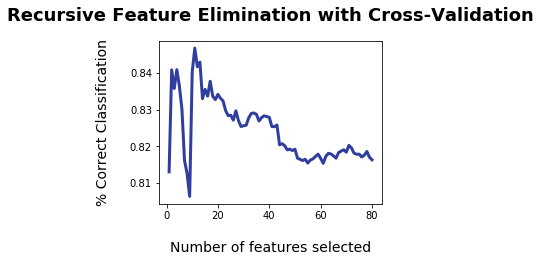

In [164]:
plt.figure(figsize=(4, 3))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

## z-scale first

In [89]:
# ##Generate training_testing & oot 
# ##only use tt to do feature selection
# tt = pd.read_csv('variables_traintest-selene.csv')

# #fix datatime 
# tt['date'] = pd.to_datetime(tt['date'])


# #remove first two weeks 
# tt_df = tt.drop(tt[tt.date < '2010-01-15'].index)

# #drop useless cols 
# tt_df.drop(['record', 'date','amount','weekday'],
#            axis=1,inplace=True)

# #Get target here to add later after z schale
# tt_y = tt_df['fraud']

# #z scale all cols expect 'fraud' and the column is constant

# tt_df = tt_df[tt_df.columns[:]].apply(lambda x: x if np.std(x) == 0 else zscore(x))
# tt_df['fraud'] = tt_y.values

In [90]:
# goods = data[data['fraud'] == 0]
# bads = data[data['fraud'] == 1]
# numbads = len(bads)

# KSFDR = pd.DataFrame()
# mydata = data.iloc[:,2:]
# KSFDR.reindex(mydata.columns)
# KSFDR['ks']=0

# for column in mydata.columns:
#     KSFDR.loc[column,'ks'] = sps.ks_2samp(goods[column],bads[column])[0]

# KSFDR

# topRows = int(round(len(mydata)*0.03))
# for column in mydata.columns:
#     temp1 = mydata.sort_values(column, ascending=False).head(topRows)
#     temp2 = mydata.sort_values(column, ascending=True).head(topRows)
#     needed1 = temp1.loc[:,'fraud']
#     needed2 = temp2.loc[:,'fraud']
#     FDR1 = sum(needed1)/numbads
#     FDR2 = sum(needed2)/numbads
#     FDRate = np.maximum(FDR1,FDR2)
#     KSFDR.loc[column,'FDR']=FDRate



# KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending=True)
# KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending=True)
# KSFDR['average_rank'] = (KSFDR['rank_ks']+KSFDR['rank_FDR'])/2

# KSFDR.sort_values(by=['average_rank'],ascending=False,inplace=True)

# KSFDR.to_csv('KSFDR.csv')

# KSFDR=KSFDR.reset_index()

# KSFDR=KSFDR.rename(columns={'index':'var'})

# KSFDR

,var,ks,FDR,rank_ks,rank_FDR,average_rank
0,fraud,1.000000,1.000000,324.0,324.0,324.00
1,card-zip_ps_7d_total,0.682004,0.634091,323.0,322.0,322.50
2,card-zip_ps_3d_total,0.673489,0.637500,320.0,323.0,321.50
3,card-merchant_ps_7d_total,0.678594,0.629545,322.0,321.0,321.50
4,card-merchant_ps_14d_total,0.673676,0.627273,321.0,319.0,320.00
...,...,...,...,...,...,...
319,random,0.017032,0.027273,1.0,36.5,18.75
320,merch#_ps_1d_ps30d_number,0.113511,0.020455,10.0,24.0,17.00
321,merch#_ps_0d_ps30d_number,0.117047,0.015909,11.0,17.5,14.25
322,merch#_ps_0d_ActualMaximum,0.122054,0.013636,13.0,14.0,13.50


## Wrapper

In [91]:
# import warnings
# warnings.filterwarnings('ignore')

# #drop 'random', 'fraud' and select top 80 variables from KSFDR 
# DFfs = KSFDR.loc[~((KSFDR['var']=='fraud') | (KSFDR['var']=='random'))]
# var_top80 = DFfs.nlargest(80,['average_rank']).copy()
# var_top80_list = list(var_top80['var'])
# var_top80_list

# ### RFECV 

# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score

# ##build modeling data x and y here

# #split x and y 
# tt_x = tt_df[tt_df.columns.intersection(var_top80_list)]
# tt_y = tt_df['fraud']

# #building X & Y array here
# tt_X = np.array(tt_x)
# tt_Y = np.array(tt_y)

# #try RRECV with 80 variables 
# model = LogisticRegression()
# rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')
# rfecv.fit(tt_X, tt_Y)




Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=3)

In [97]:
# #try RRECV with 80 variables 
# model = LogisticRegression()
# rfecv = RFECV(estimator=model, step=1, cv=2, scoring='roc_auc')
# rfecv.fit(tt_X, tt_Y)

RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=0)

In [98]:
# var80_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), tt_x.columns)),
#                             columns = ['ranking', 'variable'])
# var80_selected.head(50)



,ranking,variable
0,1,card-merchant_ps_0d_average
1,1,card-merchant_ps_0d_total
2,1,card-merchant_ps_14d_maximum
3,1,card-merchant_ps_1d_average
4,1,card-merchant_ps_30d_maximum
5,1,card-merchant_ps_30d_total
6,1,card-merchant_ps_7d_maximum
7,1,card-state_ps_3d_total
8,1,card-zip_ps_0d_maximum
9,1,card-zip_ps_0d_total


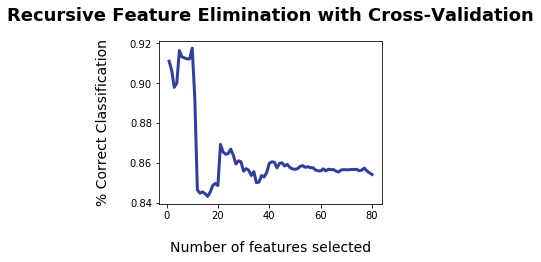

In [99]:
# plt.figure(figsize=(4, 3))
# plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
# plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

# plt.show()

In [100]:
# rfecv.grid_scores_

array([0.91101096, 0.90648018, 0.89789365, 0.90007307, 0.91635746,
       0.91322151, 0.91264001, 0.91215289, 0.91216323, 0.91756724,
       0.8925025 , 0.84644413, 0.84475299, 0.84536471, 0.84448209,
       0.84313194, 0.8452792 , 0.84859258, 0.84962835, 0.84858215,
       0.86926248, 0.86547365, 0.86428319, 0.86461603, 0.86688346,
       0.86376631, 0.85936107, 0.86101274, 0.8604584 , 0.85575969,
       0.85703785, 0.85626998, 0.8536078 , 0.85555485, 0.85002214,
       0.85032242, 0.85361936, 0.85285553, 0.85511299, 0.8597212 ,
       0.86049511, 0.8602713 , 0.85744178, 0.85973111, 0.85999597,
       0.85836435, 0.85920909, 0.85769665, 0.85693322, 0.85671481,
       0.85705981, 0.85817196, 0.85859793, 0.85771817, 0.85802917,
       0.85757151, 0.85753306, 0.85636536, 0.85597166, 0.85588101,
       0.85695558, 0.85590487, 0.85676045, 0.85654718, 0.85657933,
       0.85581824, 0.85535278, 0.8564004 , 0.85655992, 0.85649538,
       0.85647222, 0.85667656, 0.85664008, 0.85669358, 0.85602

In [94]:
# var_top30 = var80_selected.iloc[:30]
# var_top30_list = list(var_top30['variable'])
# print(var_top30_list)

['card-merchant_ps_0d_average', 'card-merchant_ps_0d_total', 'card-merchant_ps_14d_maximum', 'card-merchant_ps_1d_average', 'card-merchant_ps_30d_maximum', 'card-merchant_ps_30d_total', 'card-merchant_ps_7d_maximum', 'card-state_ps_3d_total', 'card-zip_ps_0d_maximum', 'card-zip_ps_0d_total', 'card-merchant_ps_14d_total', 'card-zip_ps_14d_total', 'card-merchant_ps_7d_total', 'merch#_ps_1d_total', 'card-zip_ps_0d_average', 'merch#_ps_3d_maximum', 'card-merchant_ps_7d_average', 'card_ps_0d_total', 'card-zip_ps_1d_total', 'card-zip_ps_3d_maximum', 'merch#_ps_1d_maximum', 'card-merchant_ps_1d_maximum', 'card-zip_ps_14d_average', 'card-merchant_ps_30d_average', 'card_ps_0d_average', 'card_ps_0d_maximum', 'card-zip_ps_30d_average', 'merch#_ps_7d_total', 'card-merchant_ps_0d_maximum', 'card-merchant_ps_3d_maximum']


In [95]:
# var_top30.to_csv('wrapper_top30.csv')
# var80_selected.to_csv('variable_ranking.csv')

### SFS

In [128]:
KSFDR.head()

,var,ks,FDR,rank_ks,rank_FDR,average_rank
0,fraud,1.000000,1.000000,324.0,324.0,324.0
1,card-state_ps_7d_total,0.551008,0.502273,323.0,322.0,322.5
2,card_ps_3d_total,0.529362,0.522727,320.0,323.0,321.5
3,card_ps_7d_total,0.547922,0.488636,322.0,320.0,321.0
4,card-state_ps_3d_total,0.537852,0.478409,321.0,319.0,320.0


In [129]:
feature = KSFDR['var'][1:71]

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
X_train,X_test,y_train,y_test=\
    train_test_split(data[feature],data['fraud'],test_size=.2,random_state=1)

In [132]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [133]:
sfs = SFS(LogisticRegression(),
           k_features=20,
           forward=True,
           verbose=3,
           scoring = 'roc_auc',
           cv = 2,
           n_jobs=-1)

In [134]:
sfs.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.8s finished

[2020-04-10 15:35:48] Features: 1/20 -- score: 0.8082047234173788[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:    2.4s finished

[2020-04-10 15:35:50] Features: 2/20 -- score: 0.8688319894090746[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:    2.9s finished

[2020-04-10 15:35:53] Features: 3/20 -- score: 0.9013367043129574[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  67 out o

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [135]:
score_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
score_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.8001605170051095, 0.816248929829648]",0.808205,"(card_ps_3d_total,)",0.0346114,0.00804421,0.00804421
2,"(1, 61)","[0.8597923835326425, 0.8778715952855065]",0.868832,"(card_ps_3d_total, merch#_ps_3d_average)",0.0388943,0.00903961,0.00903961
3,"(1, 31, 61)","[0.8922249559623191, 0.9104484526635959]",0.901337,"(card_ps_3d_total, card-zip_ps_30d_total, merc...",0.0392047,0.00911175,0.00911175
4,"(1, 22, 31, 61)","[0.8927284146981915, 0.9123136433385486]",0.902521,"(card_ps_3d_total, card-merchant_ps_14d_total,...",0.0421342,0.00979261,0.00979261
5,"(1, 22, 31, 61, 65)","[0.8964619586921083, 0.9118177065668114]",0.90414,"(card_ps_3d_total, card-merchant_ps_14d_total,...",0.0330352,0.00767787,0.00767787
6,"(1, 21, 22, 31, 61, 65)","[0.896540682884933, 0.9131080653234718]",0.904824,"(card_ps_3d_total, card-merchant_ps_7d_total, ...",0.0356418,0.00828369,0.00828369
7,"(1, 21, 22, 31, 61, 64, 65)","[0.8969231918565849, 0.9190252013151128]",0.907974,"(card_ps_3d_total, card-merchant_ps_7d_total, ...",0.0475486,0.011051,0.011051
8,"(1, 21, 22, 31, 59, 61, 64, 65)","[0.9032881411448703, 0.9146491704641189]",0.908969,"(card_ps_3d_total, card-merchant_ps_7d_total, ...",0.0244413,0.00568051,0.00568051
9,"(1, 10, 21, 22, 31, 59, 61, 64, 65)","[0.8933836803466122, 0.9155739446684318]",0.904479,"(card_ps_3d_total, card-state_ps_1d_total, car...",0.0477385,0.0110951,0.0110951
10,"(1, 10, 21, 22, 31, 34, 59, 61, 64, 65)","[0.7928713491121347, 0.8663566221320802]",0.829614,"(card_ps_3d_total, card-state_ps_1d_total, car...",0.158091,0.0367426,0.0367426


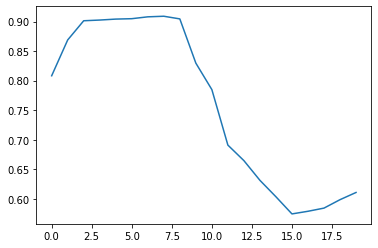

In [136]:
plt.figure()
plt.plot(range(20),score_df['avg_score'])
plt.show()

In [137]:
score_df.loc[10,'feature_names']

('card_ps_3d_total',
 'card-state_ps_1d_total',
 'card-merchant_ps_7d_total',
 'card-merchant_ps_14d_total',
 'card-zip_ps_30d_total',
 'card-state_ps_7d_average',
 'card_ps_30d_average',
 'merch#_ps_3d_average',
 'merch#_ps_3d_total',
 'card-merchant_ps_7d_maximum')